In [ ]:
#!pip install torchvision

In [2]:
import torchvision.datasets as datasets
from pathlib import Path
from collections import Counter
import torch
from torchvision.transforms import v2 as T
from torch.utils.data import DataLoader, random_split
import utils
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from torch.utils.data import Subset



from typing import Literal, List

import torchvision.models as models #para usar VGG

from PIL import Image
import os



In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
BASE_DIR = "/content/drive/MyDrive/obligatorio_generativa"
os.makedirs(BASE_DIR, exist_ok=True)

SAMPLES_DIR = f"{BASE_DIR}/samples"
CHECKPOINTS_DIR = f"{BASE_DIR}/checkpoints"

os.makedirs(SAMPLES_DIR, exist_ok=True)
os.makedirs(CHECKPOINTS_DIR, exist_ok=True)

In [6]:
transforms = T.Compose([
    T.ToImage(),
    T.ToDtype(torch.float32, scale=True),
    T.Resize((256, 256))

])

In [7]:
DATA_DIR = Path("data")

In [8]:
 #Comentamos por ahora

imagenette_dataset_train = datasets.Imagenette(
    DATA_DIR, download=True,split = 'train', transform=transforms
)
imagenette_dataset_val = datasets.Imagenette(
    DATA_DIR, download=True,split = 'val', transform=transforms
)



100%|██████████| 1.56G/1.56G [01:33<00:00, 16.6MB/s]


Probamos con menos imagenes

In [ ]:
# Cargás el dataset completo
imagenette_full = datasets.Imagenette(
    DATA_DIR, download=True, split='train', transform=transforms
)

# ID de la clase (ImagenNet synset)
selected_class = imagenette_full.class_to_idx["Tinca tinca"]

# Collect all indices for the selected class
all_class_indices = [i for i, (_, label) in enumerate(imagenette_full)
                    if label == selected_class]

# Define the number of samples for train and validation
num_train_samples = 200
num_val_samples = 20

# Ensure we have enough indices for both train and validation
# If there are fewer than num_train_samples + num_val_samples, adjust
if len(all_class_indices) < (num_train_samples + num_val_samples):
    print(f"Warning: Only {len(all_class_indices)} samples available for class '{imagenette_full.classes[selected_class]}'. Adjusting split.")
    num_train_samples = min(num_train_samples, len(all_class_indices))
    num_val_samples = min(num_val_samples, len(all_class_indices) - num_train_samples)
    # Ensure val_samples is at least 1 if there's enough data for it
    if num_val_samples == 0 and (len(all_class_indices) - num_train_samples) > 0:
        num_val_samples = 1
        num_train_samples = max(0, num_train_samples - 1) # Reduce train if needed to make space for 1 val sample
    elif num_val_samples == 0 and num_train_samples == 0 and len(all_class_indices) > 0:
        # If both are 0 but there's data, put all in train
        num_train_samples = len(all_class_indices)

# Create train and validation indices
filtered_indices_train = all_class_indices[:num_train_samples]
filtered_indices_val = all_class_indices[num_train_samples : num_train_samples + num_val_samples]

# If for some reason filtered_indices_val ended up empty, and train has data, move one from train to val
if not filtered_indices_val and filtered_indices_train:
    print("Warning: Validation set is empty, but train set has data. Moving one sample from train to validation.")
    val_sample = filtered_indices_train.pop()
    filtered_indices_val.append(val_sample)

imagenette_dataset_train = Subset(imagenette_full, filtered_indices_train)
imagenette_dataset_val = Subset(imagenette_full, filtered_indices_val)

print(f"Train dataset size: {len(imagenette_dataset_train)}")
print(f"Validation dataset size: {len(imagenette_dataset_val)}")

Train dataset size: 200
Validation dataset size: 20


In [ ]:
# hacemos 2

In [33]:
imagenette_dataset_train = Subset(imagenette_dataset_train, list(range(500)))
imagenette_dataset_val = Subset(imagenette_dataset_val, list(range(50)))

In [9]:
import sys

# definimos el dispositivo que vamos a usar
DEVICE = "cpu"  # por defecto, usamos la CPU
if torch.cuda.is_available():
    DEVICE = "cuda"  # si hay GPU, usamos la GPU
elif torch.backends.mps.is_available():
    DEVICE = "mps"  # si no hay GPU, pero hay MPS, usamos MPS
elif torch.xpu.is_available():
    DEVICE = "xpu"  # si no hay GPU, pero hay XPU, usamos XPU

print(f"Usando {DEVICE}")

NUM_WORKERS = 0 # Win y MacOS pueden tener problemas con múltiples workers
if sys.platform == 'linux':
    NUM_WORKERS = 4  # numero de workers para cargar los datos (depende de cada caso)

print(f"Usando {NUM_WORKERS}")

Usando cuda
Usando 4


In [10]:
BATCH_SIZE = 4  # tamaño del batch

In [34]:
def get_dataloaders(batch_size=BATCH_SIZE, num_workers=NUM_WORKERS):
    train_loader = DataLoader(
        imagenette_dataset_train,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
    )

    val_loader = DataLoader(
        imagenette_dataset_val,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
    )

    return train_loader, val_loader


train_loader, val_loader = get_dataloaders()

In [35]:
class DoubleConv(nn.Module):

  def __init__(self, in_ch: int, out_ch: int,
               norm: Literal['bn','gn','none'] = 'bn',
               groups: int = 8,
               dropout: float = 0.0):
    super().__init__()
    self.conv1 = nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1, bias=(norm=='none'))
    self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1, bias=(norm=='none'))
    self.norm1 = self._make_norm(norm, out_ch, groups)
    self.norm2 = self._make_norm(norm, out_ch, groups)
    #self.drop = nn.Dropout2d(dropout) if dropout and dropout > 0 else nn.Identity()
    self.act = nn.ReLU(inplace=True)

  @staticmethod
  def _make_norm(kind: str, num_ch: int, groups: int):
    if kind == 'bn':
      return nn.BatchNorm2d(num_ch)
    if kind == 'gn':
      g = min(groups, num_ch) if num_ch % groups == 0 else 1
      return nn.GroupNorm(g, num_ch)
    return nn.Identity()


  def forward(self, x: torch.Tensor) -> torch.Tensor:
    x = self.conv1(x)
    x = self.norm1(x)
    x = self.act(x)
    #x = self.drop(x)
    x = self.conv2(x)
    x = self.norm2(x)
    x = self.act(x)
    return x

In [13]:
class Down(nn.Module):
#Downscaling with maxpool then double conv
  def __init__(self, in_ch: int, out_ch: int,
                 norm: str = 'bn',
                 groups: int = 8,
                 dropout: float = 0.0):
        super().__init__()
        self.pool = nn.MaxPool2d(2)
        self.block = DoubleConv(in_ch, out_ch, norm=norm, groups=groups, dropout=dropout)

  def forward(self, x):
      x = self.pool(x)
      x = self.block(x)
      return x

In [14]:
class Up(nn.Module):
  """Upscaling then double conv
  If bilinear: use Upsample, else learned ConvTranspose2d
  """
  def __init__(self, in_ch: int, out_ch: int, bilinear: bool = True, norm: str = 'bn', groups: int = 8, dropout: float = 0.0):
    super().__init__()
    if bilinear:
      self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
      self.reduce = nn.Conv2d(in_ch, in_ch // 2, kernel_size=1)
      conv_in = in_ch // 2 + out_ch # after concat with skip (which has out_ch channels)
    else:
      self.up = nn.ConvTranspose2d(in_ch, in_ch // 2, kernel_size=2, stride=2)
      self.reduce = nn.Identity()
      conv_in = in_ch // 2 + out_ch
    self.block = DoubleConv(conv_in, out_ch, norm=norm, groups=groups, dropout=dropout)


  @staticmethod
  def _pad_to_match(x: torch.Tensor, ref: torch.Tensor) -> torch.Tensor:
    """Pad x on the right/bottom to match spatial size of ref."""
    diff_y = ref.size(2) - x.size(2)
    diff_x = ref.size(3) - x.size(3)
    if diff_x == 0 and diff_y == 0:
      return x
    return F.pad(x, [0, diff_x, 0, diff_y])


  def forward(self, x: torch.Tensor, skip: torch.Tensor) -> torch.Tensor:
    x = self.up(x)
    x = self.reduce(x)
    x = self._pad_to_match(x, skip)
    # concat along channel dim
    x = torch.cat([skip, x], dim=1)
    x = self.block(x)
    return x

In [15]:
class OutConv(nn.Module):
  def __init__(self, in_ch: int, out_ch: int=3):
    super().__init__()
    self.conv = nn.Conv2d(in_ch, out_ch, kernel_size=1)

  def forward(self, x):
    return self.conv(x)

In [16]:
class UNet(nn.Module):
    def __init__(self,
                 in_channels=1,
                 base_ch=64,
                 depth=4,              # número de downs (pools), igual que el paper
                 bilinear=True,
                 norm='bn',
                 dropout=0.0):
        super().__init__()

        # Ej: base_ch=64, depth=4 -> [64, 128, 256, 512, 1024]
        # chs[0]..chs[depth] son los canales en cada nivel de resolución
        chs = [base_ch * (2 ** i) for i in range(depth + 1)]

        # Encoder
        self.inc = DoubleConv(in_channels, chs[0], norm=norm, dropout=dropout)

        self.downs = nn.ModuleList()
        # Creamos 'depth' downs con maxpool (como el paper)
        for i in range(depth):
            self.downs.append(
                Down(chs[i], chs[i + 1], norm=norm, dropout=dropout)
            )

        # Decoder
        self.ups = nn.ModuleList()
        cur_ch = chs[-1]  # canales del nivel más profundo (ej 1024)

        # Vamos subiendo desde el fondo hasta el tope
        # i = depth-1, depth-2, ..., 0  -> skip channels = chs[i]
        for i in reversed(range(depth)):
            self.ups.append(
                Up(cur_ch, chs[i], bilinear=bilinear, norm=norm, dropout=dropout)
            )
            cur_ch = chs[i]

        self.outc = OutConv(cur_ch, 3)
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        skips = []

        # Primer nivel (sin pool)
        x = self.inc(x)
        skips.append(x)

        # Encoder con 'depth' downs (cada uno hace pool + convs)
        for down in self.downs:
            x = down(x)
            skips.append(x)

        # Ahora x está en el nivel más profundo, mismo que skips[-1]
        # No hay bottleneck extra: el último Down ya es el bloque profundo.

        # Decoder: empezamos desde la representación profunda
        x = skips.pop()  # nivel más profundo

        for up in self.ups:
            skip = skips.pop()   # skip correspondiente de encoder
            x = up(x, skip)

        x = self.outc(x)
        return x


In [17]:
class StyleTransferNet(nn.Module):
    def __init__(self, **unet_kwargs):
        super().__init__()
        self.transform = UNet(**unet_kwargs)

    def forward(self, x):
        return self.transform(x)

In [18]:
IMAGENET_MEAN = torch.tensor([0.485, 0.456, 0.406]).view(1,3,1,1)
IMAGENET_STD  = torch.tensor([0.229, 0.224, 0.225]).view(1,3,1,1)

In [19]:
def vgg_normalize(x: torch.Tensor) -> torch.Tensor:
    # x debe estar en [0,1] para esto. Si tu U-Net devuelve [-1,1], primero reescalá.
    return (x - IMAGENET_MEAN.to(x.device)) / IMAGENET_STD.to(x.device)

In [20]:
class VGGFeatureExtractor(nn.Module):
    """
    Devuelve features de capas intermedias.
    Las indices dependen de la definicion de vgg19.features
    """
    def __init__(self, content_layers=None, style_layers=None):
        super().__init__()
        vgg = models.vgg19(weights=models.VGG19_Weights.IMAGENET1K_V1).features
        self.vgg = vgg.eval()
        for p in self.vgg.parameters():
            p.requires_grad = False

        # indices de capas (puedes ajustarlos)
        # estos corresponden a relu1_2, relu2_2, relu3_3, relu4_3 aprox.
        self.content_layers = content_layers or ['8']      # por ej relu2_2
        self.style_layers   = style_layers   or ['3','8','15','22']

    def forward(self, x):
        features = {}
        for i, layer in enumerate(self.vgg):
            x = layer(x)
            name = str(i)
            if name in self.content_layers or name in self.style_layers:
                features[name] = x
        return features

In [21]:
def gram_matrix(feat: torch.Tensor) -> torch.Tensor:
    # feat: [B, C, H, W]
    B, C, H, W = feat.shape
    F_ = feat.view(B, C, H * W)
    G = torch.bmm(F_, F_.transpose(1, 2))  # [B, C, C]
    return G / (C * H * W)


def total_variation_loss(x: torch.Tensor) -> torch.Tensor:
    # suaviza la imagen, penaliza cambios bruscos
    loss_h = torch.mean(torch.abs(x[:, :, 1:, :] - x[:, :, :-1, :]))
    loss_w = torch.mean(torch.abs(x[:, :, :, 1:] - x[:, :, :, :-1]))
    return loss_h + loss_w

In [22]:
class PerceptualLoss(nn.Module):
    def __init__(self,
                 vgg_extractor: VGGFeatureExtractor,
                 style_img: torch.Tensor,
                 content_weight=0.01,
                 style_weight=1e4,
                 tv_weight=1e-6):
        super().__init__()
        self.vgg = vgg_extractor
        self.cw = content_weight
        self.sw = style_weight
        self.tvw = tv_weight

        with torch.no_grad():
            # estilo en [0,1] y normalizado a ImageNet
            self.style_grams = self._compute_style_grams(style_img)

    def _compute_style_grams(self, style_img: torch.Tensor):

        # style_img debería ser [1, 3, 256, 256] en [0,1]
        assert style_img.dim() == 4, f"style_img dim {style_img.dim()}"
        B, C, H, W = style_img.shape
        assert C == 3, f"style_img C={C}, esperado 3"
        assert H >= 64 and W >= 64, f"style_img muy chica: {H}x{W}"


        """
        style_img: [1,3,H,W] en [0,1]
        """
        style_norm = vgg_normalize(style_img)
        feats = self.vgg(style_norm)
        grams = {}
        for name in self.vgg.style_layers:
            grams[name] = gram_matrix(feats[name])
        return grams

    def forward(self, output: torch.Tensor, content: torch.Tensor) -> torch.Tensor:
        for name, t in [("output", output), ("content", content)]:
          assert t.dim() == 4, f"{name} dim {t.dim()}"
          B, C, H, W = t.shape
          assert C == 3, f"{name} C={C}, esperado 3"
          assert H >= 64 and W >= 64, f"{name} muy chico: {H}x{W}"
        """
        output, content: [B,3,H,W], ambos en [0,1]
        """
        out_norm = vgg_normalize(output)
        cont_norm = vgg_normalize(content)

        feats_out = self.vgg(out_norm)
        feats_cont = self.vgg(cont_norm)

        # Content loss: usar una sola capa (ej relu2_2 -> '8')
        content_loss = 0.0
        for name in self.vgg.content_layers:
            content_loss += F.mse_loss(feats_out[name], feats_cont[name])

        # Style loss: comparar Gram matrices
        style_loss = 0.0
        for name in self.vgg.style_layers:
            G_out = gram_matrix(feats_out[name])   # [B, C, C]
            G_style = self.style_grams[name]       # [1, C, C]

            # replicar el estilo para que tenga el mismo batch size
            if G_style.size(0) == 1 and G_out.size(0) > 1:
                G_style = G_style.expand(G_out.size(0), -1, -1)  # [B, C, C]

            style_loss += F.mse_loss(G_out, G_style)

        tv_loss = total_variation_loss(output)

        loss = self.cw * content_loss + self.sw * style_loss + self.tvw * tv_loss
        return loss, content_loss, style_loss, tv_loss

In [38]:
model = StyleTransferNet(
    in_channels=3,
    base_ch=64, # era 64. lo baje porque me daba error de capacidad la GPU
    depth=4,
    bilinear=True,
    norm='gn',
    dropout=0.0,
).to(DEVICE)

In [39]:
vgg_extractor = VGGFeatureExtractor(
    content_layers=['8'],                 # una capa para contenido
    style_layers=['3', '8', '15', '22']   # varias capas para estilo
).to(DEVICE)

In [40]:
style_transform = T.Compose([
    T.ToImage(),
    T.ToDtype(torch.float32, scale=True),
    T.Resize((256,256)),
])


In [41]:
# Cargo imagen de estilo
style_img_pil = Image.open("style_img.jpg").convert("RGB")

In [42]:
style_img = style_transform(style_img_pil).unsqueeze(0).to(DEVICE)

In [43]:
style_img.shape

torch.Size([1, 3, 256, 256])

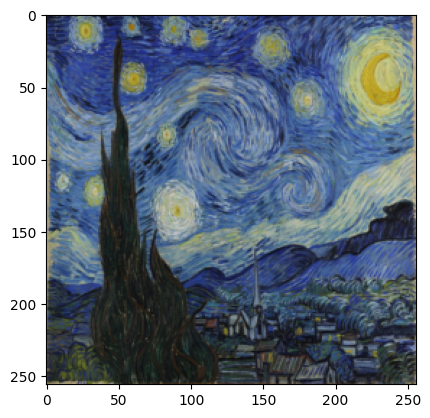

In [44]:
#mostramos la style_img
plt.imshow(style_img.cpu().squeeze(0).permute(1, 2, 0).numpy())

In [45]:
criterion = PerceptualLoss(
    vgg_extractor=vgg_extractor,
    style_img=style_img,
    content_weight=0.05,
    style_weight=1e4,
    tv_weight=1e-6
)

In [46]:
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=1e-3,
    betas=(0.9, 0.999)
)

In [47]:
train_loss, val_loss = utils.train(model,optimizer,criterion,train_loader,val_loader,DEVICE,True,patience=20,epochs = 200,ruta_img = SAMPLES_DIR)

Epoch: 001 | Train Loss: 55.81667 | Val Loss: 1.80590
Epoch: 002 | Train Loss: 1.42567 | Val Loss: 1.21081
Epoch: 003 | Train Loss: 1.07640 | Val Loss: 1.02311
Epoch: 004 | Train Loss: 0.93231 | Val Loss: 0.92029
Epoch: 005 | Train Loss: 0.86289 | Val Loss: 0.85453
Epoch: 006 | Train Loss: 0.79919 | Val Loss: 0.81554
Epoch: 007 | Train Loss: 0.76029 | Val Loss: 0.76611
Epoch: 008 | Train Loss: 0.72787 | Val Loss: 0.73199
Epoch: 009 | Train Loss: 0.71038 | Val Loss: 0.71590
Epoch: 010 | Train Loss: 0.67255 | Val Loss: 0.66854
Epoch: 011 | Train Loss: 0.65439 | Val Loss: 0.67019
Epoch: 012 | Train Loss: 0.63402 | Val Loss: 0.64417
Epoch: 013 | Train Loss: 0.61875 | Val Loss: 0.64176
Epoch: 014 | Train Loss: 0.61457 | Val Loss: 0.64886
Epoch: 015 | Train Loss: 0.59429 | Val Loss: 0.62092
Epoch: 016 | Train Loss: 0.58053 | Val Loss: 0.63186
Epoch: 017 | Train Loss: 0.57010 | Val Loss: 0.58830
Epoch: 018 | Train Loss: 0.55820 | Val Loss: 0.58819
Epoch: 019 | Train Loss: 0.54777 | Val Loss: 

In [48]:
# Guardamos el modelo
torch.save(model.state_dict(), "style_transfer_unet.pth")

In [37]:
import gc

#del model  # si ya lo tenías creado
#gc.collect()
#torch.cuda.empty_cache()

Probamos el modelo

In [49]:
# Cargo imagen de estilo
img_test = Image.open("suarez.jpg").convert("RGB")

In [50]:
img_test = style_transform(img_test).unsqueeze(0).to(DEVICE)

In [51]:
img_test.shape

torch.Size([1, 3, 256, 256])

In [52]:
img_test

tensor([[[[0.3096, 0.2930, 0.2763,  ..., 0.2194, 0.2316, 0.2544],
          [0.3065, 0.2924, 0.2788,  ..., 0.2162, 0.2306, 0.2511],
          [0.3036, 0.2900, 0.2772,  ..., 0.2145, 0.2283, 0.2459],
          ...,
          [0.0350, 0.0364, 0.0412,  ..., 0.7548, 0.7133, 0.6736],
          [0.0413, 0.0415, 0.0444,  ..., 0.7388, 0.6975, 0.6575],
          [0.0468, 0.0451, 0.0472,  ..., 0.7245, 0.6857, 0.6450]],

         [[0.0465, 0.0523, 0.0612,  ..., 0.2128, 0.2095, 0.2169],
          [0.0508, 0.0562, 0.0685,  ..., 0.2096, 0.2086, 0.2136],
          [0.0553, 0.0629, 0.0770,  ..., 0.2077, 0.2063, 0.2085],
          ...,
          [0.0355, 0.0368, 0.0416,  ..., 0.8033, 0.7852, 0.7671],
          [0.0413, 0.0415, 0.0444,  ..., 0.7914, 0.7750, 0.7567],
          [0.0468, 0.0451, 0.0472,  ..., 0.7820, 0.7665, 0.7475]],

         [[0.0590, 0.0646, 0.0742,  ..., 0.2226, 0.2159, 0.2210],
          [0.0675, 0.0750, 0.0858,  ..., 0.2195, 0.2149, 0.2177],
          [0.0696, 0.0787, 0.0918,  ..., 0

In [53]:
with torch.no_grad():
            # estilo en [0,1] y normalizado a ImageNet
            output = model(img_test)

In [ ]:
output

In [54]:
import matplotlib.pyplot as plt

In [55]:
output = output.detach().cpu()

In [56]:
out_01 = (output + 1) / 2

In [57]:
img = out_01.squeeze(0).permute(1, 2, 0).numpy()

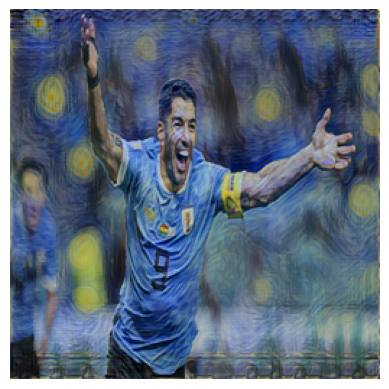

In [58]:
plt.imshow(img)
plt.axis("off")
plt.show()